In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)

2.15.0


In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [ ]:
dataset.isna().sum()
dataset = dataset.dropna()

In [ ]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
393,27.0,4,140.0,86.0,2790.0,15.6,82
394,44.0,4,97.0,52.0,2130.0,24.6,82
395,32.0,4,135.0,84.0,2295.0,11.6,82
396,28.0,4,120.0,79.0,2625.0,18.6,82
397,31.0,4,119.0,82.0,2720.0,19.4,82


In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


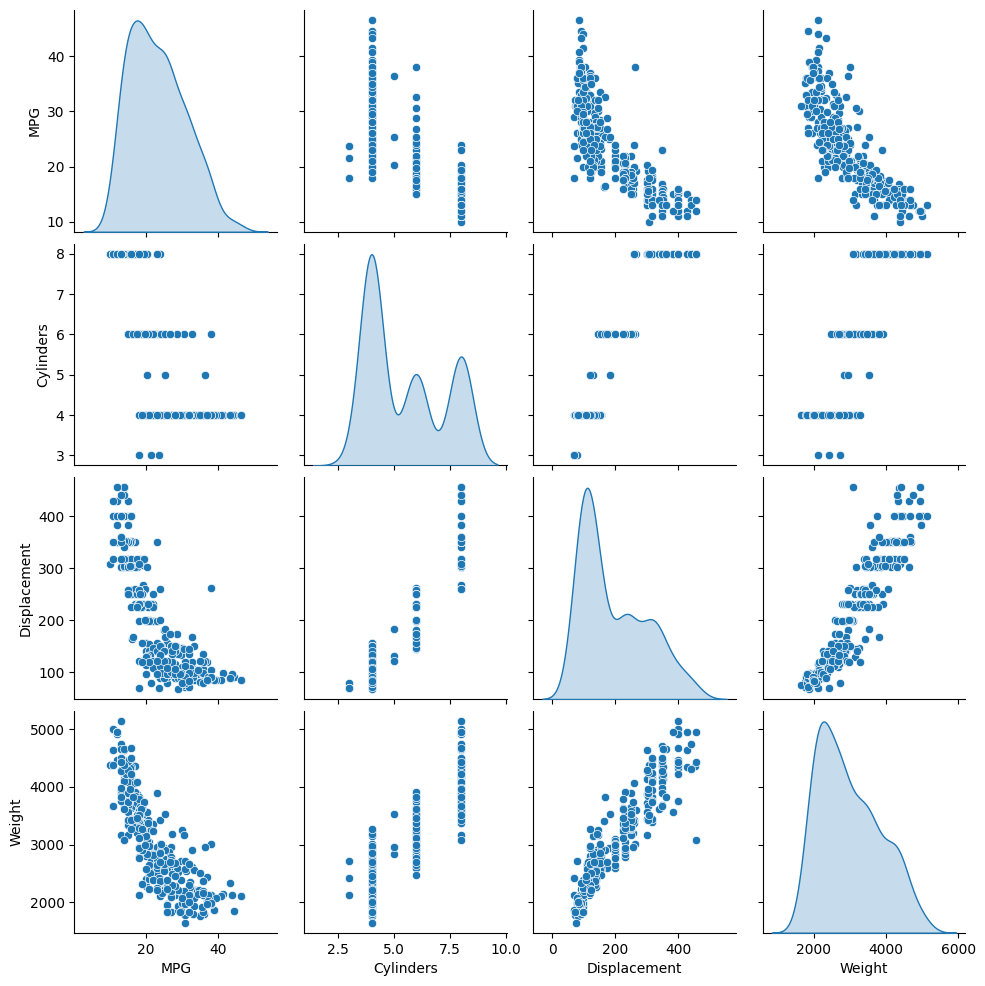

In [ ]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
train_dataset.describe().transpose()

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')


In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898]]


In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52]]


In [ ]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    tf.keras.layers.Dense(units=1)
])

horsepower_model.summary()
horsepower_model.predict(horsepower[:10])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_11 (Normaliz  (None, 1)                 3         
 ation)                                                          
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________
1/1 [==============================] - 0s 140ms/step


array([[-1.128],
       [-0.637],
       [ 2.082],
       [-1.581],
       [-1.43 ],
       [-0.562],
       [-1.695],
       [-1.43 ],
       [-0.373],
       [-0.637]], dtype=float32)

In [ ]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
    metrics=["accuracy"]
)

history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,3.809839,0.0,4.176461,0.0,95
96,3.804190,0.0,4.194818,0.0,96
97,3.804774,0.0,4.168040,0.0,97
98,3.804518,0.0,4.186657,0.0,98
99,3.804345,0.0,4.190876,0.0,99


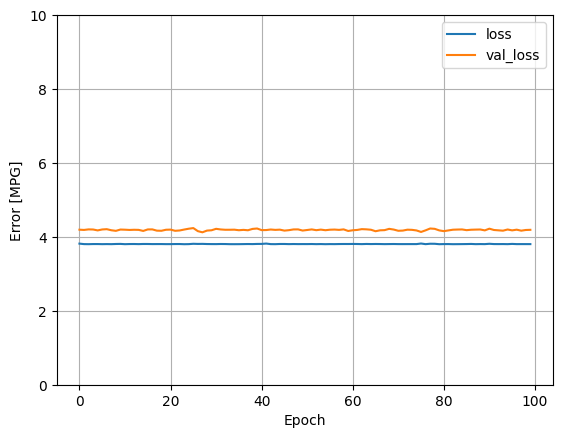

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

8/8 [==============================] - 0s 10ms/step


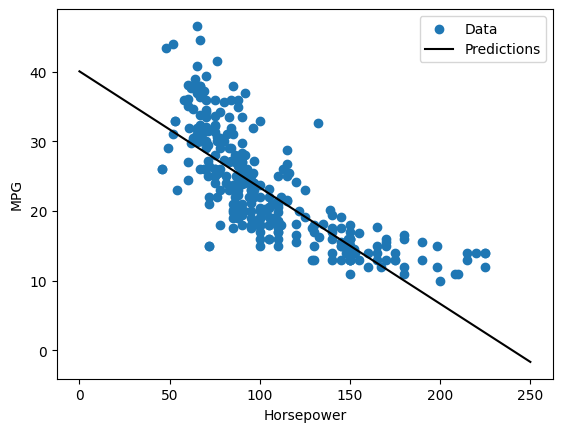

In [ ]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(x, y)

1/1 [==============================] - 0s 56ms/step
Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 22.9141
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 21.8817
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 20.8772
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 19.8753
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 18.8837
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 17.8885
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 16.8987
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 15.8943
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 14.8852
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 13.8991
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 12.9005
Epoch 12/100
10/10 [==============================] - 0

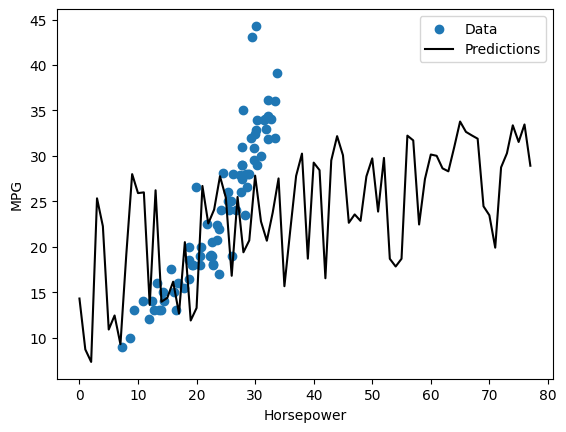

In [65]:
linear_model=tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=1)

])

linear_model.predict(train_features[:10])

# linear_model.layers[1].kernel
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)
linear_model.fit( train_features,
    train_labels,
    epochs=100,)

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

x = tf.linspace(0.0, 77, 78)
y = linear_model.predict(test_features)

def plot_horsepower(x, y):
  plt.scatter(x,test_labels ,label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(x, y)

Text(0, 0.5, 'Predictions [MPG]')

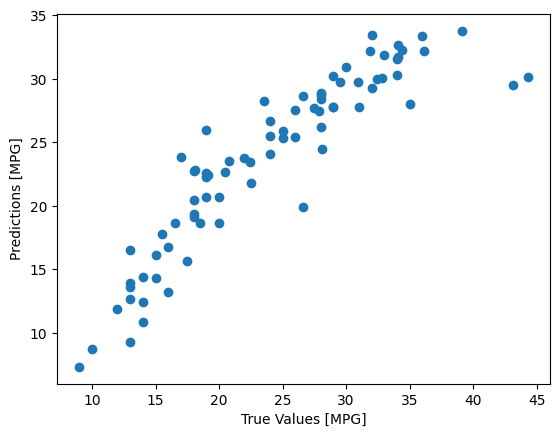

In [66]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, y)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')

In [70]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [71]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()
history=dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 6)                 13        
 tion)                                                           
                                                                 
 dense_28 (Dense)            (None, 64)                448       
                                                                 
 dense_29 (Dense)            (None, 64)                4160      
                                                                 
 dense_30 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4686 (18.31 KB)
Trainable params: 4673 (18.25 KB)
Non-trainable params: 13 (56.00 Byte)
_________________________________________________________________


In [72]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)


3/3 [==============================] - 0s 4ms/step


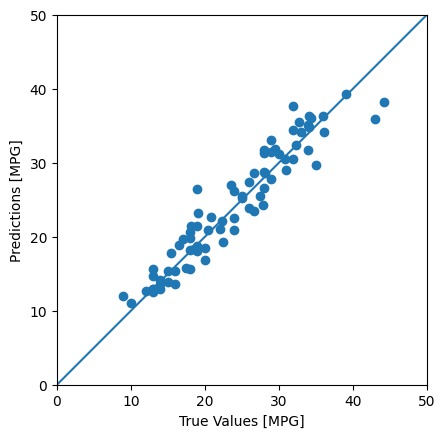

In [73]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

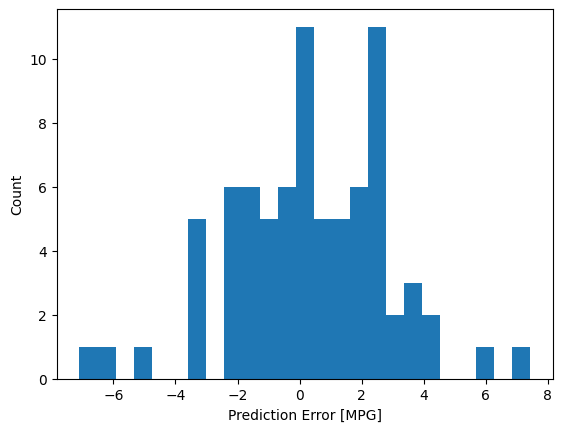

In [74]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [75]:
dnn_model.save('dnn_model.keras')